# SET UP

In [64]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error
from xgboost import XGBRegressor


In [2]:
# Configurations
pd.set_option('display.max_columns', None)

In [3]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [4]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [5]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 100 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles']]
    


In [6]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


In [7]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


# CALCULATIONS

TODO:
- [ ] Calculate league averages
- [ ] Calculate OL factors
- [ ] See if we can weigh xCmp
- [ ] Evaluate differences between xCmp and actual completions

In [8]:
# xAtt = pass attempts - throwaways - spikes
# This discounts pass attempts where no receiver was intentionally targeted
#
# NOTE: It is possible we may not want to subtract throwaways since it doesn't 
# account if there was a receiver open but the QB could not make the read

def xAtt(row):
    return row['pass_att'] - row['pass_spikes']

In [9]:
# xCmp = OnTgt throws - Bad throws + Drops
# This adds up pass attempts that where good enough to be completions (i.e. OnTgt throws) and drops that should've been caught. 
# It also subtracts pass attempts that are typically not completed  (i.e. Bad throws). These all add up to what the QB's total 
# number of completions should have been based on these stats.
#
# NOTE: the definition of "OnTgt" and "bad" throws is subjective. According
# to PFR, "bad" throws are passes that cannot be caught with "normal" effort, although
# this doesn't necessarily mean the pass is uncatchable. Similarly, "OnTgt" is not 
# specifically defined either.

def xCmp(row):
    return row['pass_on_target'] - row['pass_poor_throws'] + row['pass_drops']

In [10]:
# xCmp% = xCmp/xAtt

def xCmpPct(row):
    return float(row['xCmp']/row['xAtt']) * 100

In [11]:
# basic cmp%, i.e. cmp% = cmp/att

def cmpPct(row):
    return float(row['pass_cmp']/row['pass_att']) * 100

In [12]:
# cmpDiff = xCmp - Cmp

def cmpDiff(row):
    return row['xCmp'] - row['pass_cmp']

In [13]:
# cmpPctDiff = xCmp% - CmpPct

def cmpPctDiff(row):
    return float(row['xCmpPct']) - float(row['cmpPct'])

In [14]:
# Add in calculations into dataframes

for x in years:
    df = data[x]
    df['xAtt'] = df.apply(xAtt, axis=1)
    df['xCmp'] = df.apply(xCmp, axis=1)
    df['xCmpPct'] = df.apply(xCmpPct, axis=1)
    df['cmpPct'] = df.apply(cmpPct, axis=1)
    df['cmpDiff'] = df.apply(cmpDiff, axis=1)
    df['cmpPctDiff'] = df.apply(cmpPctDiff, axis=1)

## Visualize Basic xCmp

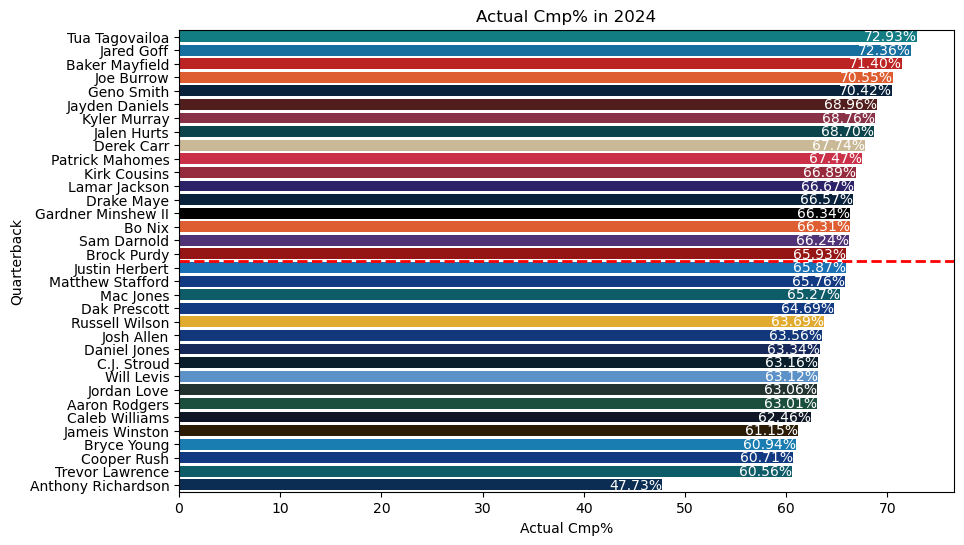

In [15]:
# Plot 2024 data as a test

cmp24 = statGrapher(data[24], 'cmpPct', 'Actual Cmp%')

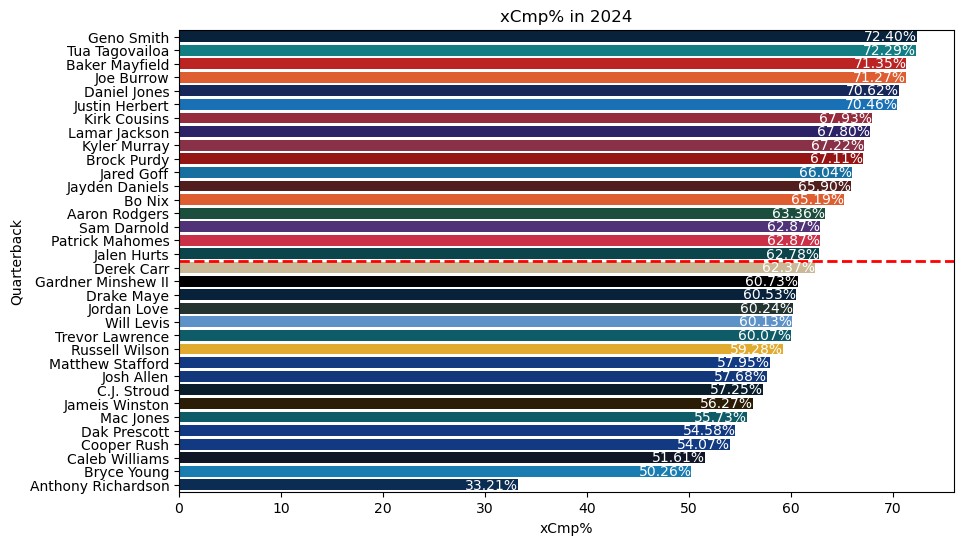

In [16]:
# 2024 xCmp%

xCmp24 = statGrapher(data[24], 'xCmpPct', 'xCmp%')

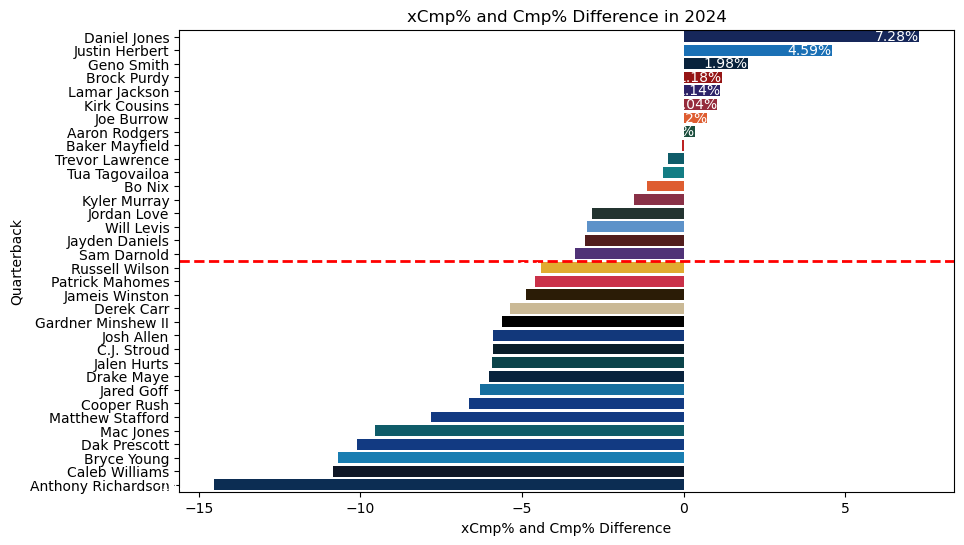

In [17]:
cmpDiff24 = statGrapher(data[24], 'cmpPctDiff', 'xCmp% and Cmp% Difference') 

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

# FITTING MODELS

In [15]:
data_total = pd.DataFrame()

for x in years:
    df = data[x]
    df['Season'] = "20" + str(x)
    data_total = pd.concat([data_total, df], axis=0)

In [71]:
# Create X and y

X = data_total[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops']]
y = data_total[['pass_cmp']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# create xgb model

xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=42
)



In [19]:
xgbCmp_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [59]:
y_pred = xgbCmp_model.predict(X_test)

y_train_pred = xgbCmp_model.predict(X_train)

In [60]:
# Evaluation Metrics for TESTING data

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² for testing data: {r2}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) for testing data: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) for testing data: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) for testing data: {rmse}")

R² for testing data: 0.9853442907333374
Mean Absolute Error (MAE) for testing data: 7.650755405426025
Mean Squared Error (MSE) for testing data: 103.00018310546875
Root Mean Squared Error (RMSE) for testing data: 10.148900586047178


In [61]:
# Evaluation Metrics for TRAINING data

# Calculate R² score
r2 = r2_score(y_train, y_train_pred)
print(f"R² for training data: {r2}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Mean Absolute Error (MAE) for testing data: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error (MSE) for training data: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) for training data: {rmse}")

R² for training data: 0.997066855430603
Mean Absolute Error (MAE) for testing data: 3.345041275024414
Mean Squared Error (MSE) for training data: 18.496849060058594
Root Mean Squared Error (RMSE) for training data: 4.300796328595275


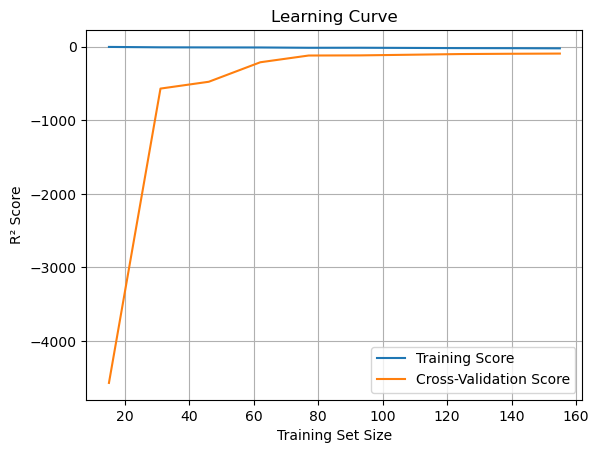

In [72]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmp_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

### Notes on Training vs Testing Eval Metrics

The training RMSE (i.e. 4.3008) is considerably better better than the testing RMSE (i.e. 10.1489). Similarly, the MAE for the training data (i.e. 3.345) is considerably lower than the MAE for the training data (7.651). This suggests this model is overfitted.

While I believe both scores are quite good (and they have a similar $R^2$ of 0.9853 for testing and 0.99707 for testing), the difference of $\approx 5.85$ cmps between testing and training data can be considered non-insignificant. After all, that's more than double. Furthermore, if we assume the average number of completions by a QB over a season is around 300, then the MAE of 3.345 or 7.651 are both relatively low. But once again, the testing data's MAE is double that of the training data's MAE, which is a pretty alarming difference.

Moreover, given the already relatively limited sample size of passers, can we trust this model's accuracy over long-term xCmp calculations? Additionally, how can we ensure we didn't get lucky with this particular model and that if we consistently used these features to calculate xCmp, we can consistently get good RMSE numbers (e.g. what if we got lucky with this seed)? Also, the MSE is very different, implying the testing data had some outliers the model poorly fitted. It is unclear whether this is because the model is overfitted or because the outliers in the testing data are that extreme. 

Considering the high amount of variance in football, it's possible these differences in evaluation scores are not abnormal. Additionally, since XGBoost models are quite complex and powerful, differences between testing/training evaluation metrics are expected. Once again, both metric numbers in context are not dramatic. There should be a difference between completions and xCmp anyway, given how xCmp is supposed to be what the QB *should* achieve rather than what they did achieve.

The learning curve provides conflicting evidence, as the training score's constant high score (regardless of scoring metric) suggests the model is well-fitted or even under-fitted. The cross-validation score's behavior (also regardless of scoring metric) tends to increase sharply before plateauing at around size 80. This behavior also contradicts the idea that the model is overfitting. However, it should be noted that the training score's constantly perfect score could be an error from the learning curve plot.

##### Current Parameters
```
xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=42
)
```

##### Possible Improvements
- Figure out ways to reduce overfititng in XGBoost models in general (i.e. greater max_depth, n_estimators, etc.)
- Feature engineering

In [37]:
data_total['xgbCmp'] = xgbCmp_model.predict(X)

data_total['xgbCmpPct'] = (data_total['xgbCmp']/data_total['xAtt']) * 100

data_total['xgbCmpPctDiff'] = (data_total['xgbCmpPct'] - data_total['cmpPct'])

# EXPORTING NEW DATAFRAMES

In [ ]:
# Export dfs to CSVs

for x in years:
    df = data[x]
    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)

# CREATING VISUALS

### Visualize Model

In [38]:
# Filter model data so it's 2024

data24 = data_total[data_total['Season'] == "2024"]

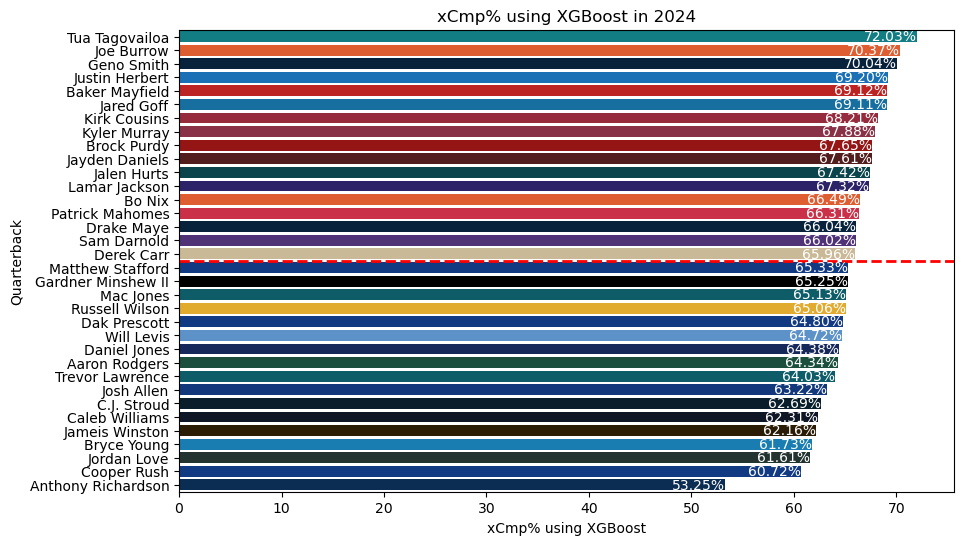

In [39]:

xCmp24LinReg = statGrapher(data24, 'xgbCmpPct', 'xCmp% using XGBoost')

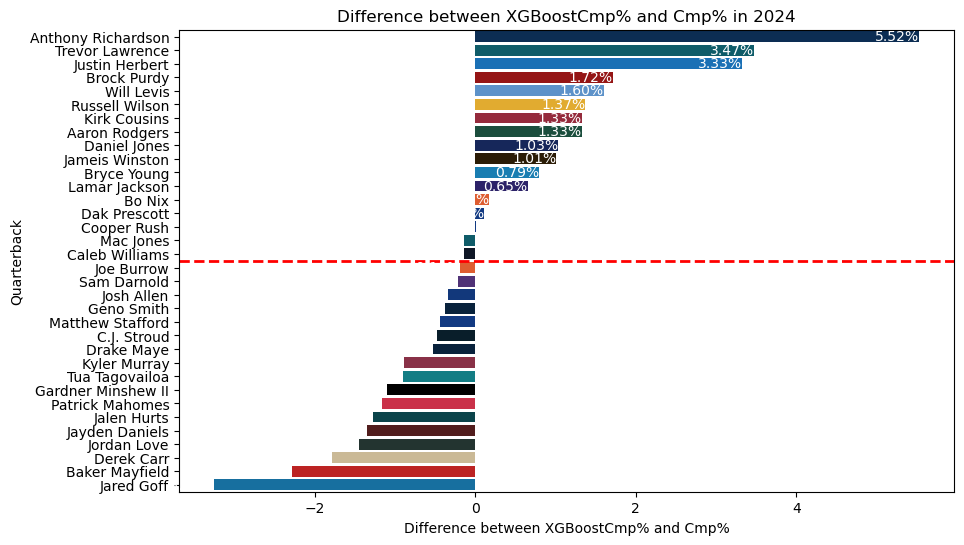

In [41]:
# 2024 xCmp% based on model

xCmp24LinRegPctDiff = statGrapher(data24, 'xgbCmpPctDiff', 'Difference between XGBoostCmp% and Cmp%')

In [ ]:
data24.head()